<a href="https://colab.research.google.com/github/UmarIgan/Machine-Learning/blob/master/examples/image_captioning_blip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [5]:
!pip install git+https://github.com/huggingface/transformers.git@main
!pip install datasets

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-ijrca3gv
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ijrca3gv
  Resolved https://github.com/huggingface/transformers.git to commit 48101cf8d127bbf22d751c7df118a6ce357e2e27
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.45.0.dev0-py3-none-any.whl size=9503319 sha256=84460b0069c7aa6d4b71f4890d5a8c26393e7c863aa9cf1d7b2714944ded687c
  Stored in directory: /tmp/pip-ephem-wheel-cache-4i_tqt82/wheels/cf/59/82/6492402e887a68975030bf8c06532260abc16abb7ccd8127cc
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [1]:
from transformers.utils import send_example_telemetry

send_example_telemetry("image_captioning_blip_notebook", framework="pytorch")
#https://github.com/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [2]:
from datasets import load_dataset
import torch
from tqdm import tqdm
import time
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch.utils.data import Dataset, DataLoader

In [3]:
dataset = load_dataset("Shrey-1329/cxiu_hf_dataset", split="train[:1000]")

Let's retrieve the caption of the first example:

In [4]:
dataset[0]["text"]

'there is  increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation the cardiac silhouette is within normal limits  opacity in the left midlung overlying the posterior left th rib may represent focal airspace disease no pleural effusion or pneumothorax no acute bone abnormality'

And the corresponding image

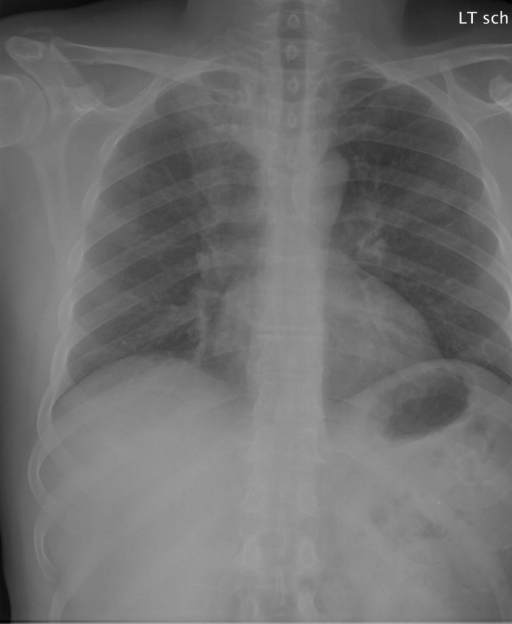

In [5]:
dataset[0]["image"]

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [6]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [7]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [8]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
start_time = time.time()

for epoch in range(10):
    print(f"Epoch: {epoch+1}/{10}")

    # Initialize tqdm progress bar for the batches in each epoch
    with tqdm(total=len(train_dataloader), desc=f"Training Epoch {epoch+1}") as pbar:
        for idx, batch in enumerate(train_dataloader):
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

            loss = outputs.loss

            # Update the progress bar description with the current loss
            pbar.set_postfix({"Loss": loss.item()})
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update tqdm progress bar
            pbar.update(1)

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training completed in: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.0f} seconds")

Epoch: 1/10


Training Epoch 1: 100%|██████████| 500/500 [05:20<00:00,  1.56it/s, Loss=0.319]


Epoch: 2/10


Training Epoch 2: 100%|██████████| 500/500 [05:19<00:00,  1.57it/s, Loss=0.0388]


Epoch: 3/10


Training Epoch 3: 100%|██████████| 500/500 [05:19<00:00,  1.56it/s, Loss=0.106]


Epoch: 4/10


Training Epoch 4: 100%|██████████| 500/500 [05:25<00:00,  1.54it/s, Loss=0.0462]


Epoch: 5/10


Training Epoch 5: 100%|██████████| 500/500 [05:14<00:00,  1.59it/s, Loss=0.0162]


Epoch: 6/10


Training Epoch 6: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s, Loss=0.0201]


Epoch: 7/10


Training Epoch 7: 100%|██████████| 500/500 [05:27<00:00,  1.52it/s, Loss=0.0262]


Epoch: 8/10


Training Epoch 8: 100%|██████████| 500/500 [05:16<00:00,  1.58it/s, Loss=0.0125]


Epoch: 9/10


Training Epoch 9: 100%|██████████| 500/500 [05:14<00:00,  1.59it/s, Loss=0.0157]


Epoch: 10/10


Training Epoch 10: 100%|██████████| 500/500 [05:18<00:00,  1.57it/s, Loss=0.0208]

Training completed in: 53 minutes and 29 seconds


## Inference

Let's check the results on our train dataset

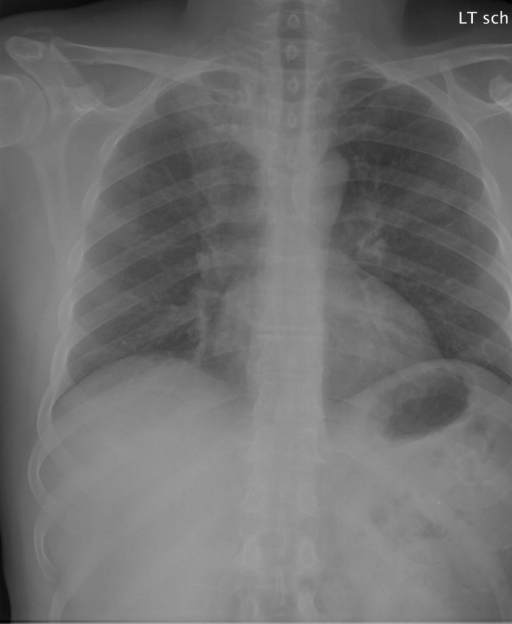

In [10]:
# load image
example = dataset[0]
image = example["image"]
image

In [11]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the heart and lungs have in the interval both lungs are clear and expanded heart and mediastinum normal


In [12]:
example['text']

'there is  increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation the cardiac silhouette is within normal limits  opacity in the left midlung overlying the posterior left th rib may represent focal airspace disease no pleural effusion or pneumothorax no acute bone abnormality'

## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [13]:
model.push_to_hub("umarigan/blip-image-captioning-base-chestxray-finetuned")
processor.push_to_hub("umarigan/blip-image-captioning-base-chestxray-finetuned")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/umarigan/blip-image-captioning-base-chestxray-finetuned/commit/62ba873d4eef7139dfd33affa9aa68a530c7f67b', commit_message='Upload processor', commit_description='', oid='62ba873d4eef7139dfd33affa9aa68a530c7f67b', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("umarigan/blip-image-captioning-base-chestxray-finetuned").to(device)
processor = AutoProcessor.from_pretrained("umarigan/blip-image-captioning-base-chestxray-finetuned")

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/431 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Let's check the results on our train dataset!

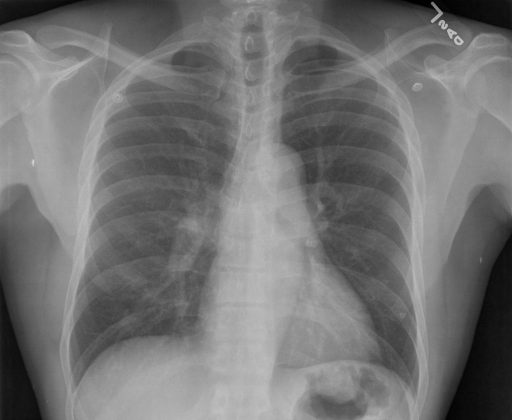

In [16]:
example = dataset[990]
image = example["image"]
image

In [17]:
example["text"]

'normal heart clear lungs stable calcified granuloma left midlung no pneumothorax no pleural effusion midline trachea'

In [18]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the heart and lungs have in the interval both lungs are clear and expanded heart and mediastinum normal
